In [2]:
%reload_ext autoreload
%autoreload 2
import torch
from fastai.vision.all import *
import json

In [3]:
import sys
sys.path.append('../')
%env DISENTANGLEMENT_LIB_DATA=/data/disentanglement

env: DISENTANGLEMENT_LIB_DATA=/data/disentanglement


In [4]:
import wandb

In [5]:
def get_df(runs):
    id_df=pd.DataFrame({'id':[run.id for run in runs]})
    summary_df = pd.DataFrame.from_records([{k:v for k,v in run.summary._json_dict.items() if not k.startswith('_')} for run in runs]) 
    config_df = pd.DataFrame.from_records([{k:v for k,v in run.config.items() if not k.startswith('_')} for run in runs])
    return pd.concat([id_df,config_df,summary_df],axis=1)

In [6]:
from disvae import init_specific_model
def get_representation_fn(run,img_shape=[1,64,64],device='cuda',model_file="model.pt"):
    group=run.config['group']
    dim=run.config['latent_dim']
    model_type=run.config['model_type']
    simultaneous = run.config['simultaneous']
    model = init_specific_model(model_type,img_shape,dim,group)
    ans = run.file(model_file).download('tmp',True)
    model.load_state_dict(torch.load(ans.name))
    model.to(device)
    model.phase=4
    model.eval()
    def representation_fn(obs):
        obs = torch.tensor(obs.transpose([0,3,1,2]),dtype=torch.float32,device=device)
        with torch.no_grad():
            mean,_ = model.encoder(obs)
        return mean.cpu().numpy()
    return representation_fn,model

In [7]:
api = wandb.Api()

In [8]:
from disentanglement_lib.evaluation.metrics import mig,factor_vae,dci,modularity_explicitness,sap_score
from disentanglement_lib.data.ground_truth.named_data import get_named_ground_truth_data

In [9]:
import gin

In [10]:
gin.parse_config_file('metrics_config.gin',True)

ParsedConfigFileIncludesAndImports(filename='metrics_config.gin', imports=[], includes=[])

In [11]:
def update_metrics(r,dataset):
    representation_fn,model=get_representation_fn(r,r.config['img_size'])
    
    metrics_dict={}
    print(time.asctime())
    for metric_fn in [mig.compute_mig,
                      factor_vae.compute_factor_vae,
                      dci.compute_dci,
                      modularity_explicitness.compute_modularity_explicitness,
                      sap_score.compute_sap]:
        m=metric_fn(dataset,representation_fn,np.random.RandomState())
        print(time.asctime(),m)
        metrics_dict.update(m)
    r.summary.update(metrics_dict)
    print("updated ", r.name, r.url)

In [17]:
runs = api.runs("erow/fractionVAE",{"$and":[{"config.dataset":"smallnorb"},
                                            {"config.base":"30,15,8"},
                                            {"tags":"compararison"},
#                                             {"config.beta":3},
                                           {"state":"finished"}]})
runs

<Runs erow/fractionVAE (6)>

{'bodies': [<matplotlib.collections.PolyCollection at 0x7fcdd445c4d0>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x7fcdd53f1310>,
 'cmins': <matplotlib.collections.LineCollection at 0x7fcdd5265890>,
 'cbars': <matplotlib.collections.LineCollection at 0x7fcdd45ef9d0>}

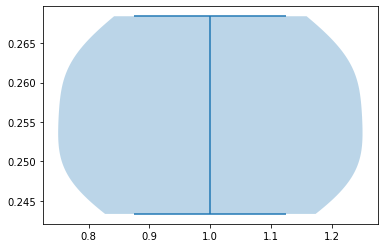

In [20]:
df = get_df(runs,)
plt.violinplot(df['discrete_mig'])

In [13]:
df.keys()

Index(['id', 'lr', 'base', 'beta', 'loss', 'name', 'seed', 'group', 'device',
       'epochs', 'betaB_G', 'betaH_B', 'dataset', 'lr_disc', 'monitor',
       'no_test', 'anneal_l', 'anneal_r', 'btcvae_A', 'btcvae_B', 'btcvae_G',
       'factor_G', 'img_size', 'lr_decay', 'rec_dist', 'log_level',
       'batch_size', 'betaB_finC', 'is_metrics', 'latent_dim', 'model_type',
       'anneal_name', 'betaB_initC', 'anneal_count', 'is_eval_only',
       'simultaneous', 'eval_batchsize', 'no_progress_bar', 'checkpoint_every',
       'kl_1', 'kl_3', 'kl_8', 'loss', 'anneal_reg', 'discrete_mig', 'kl_0',
       'kl_4', 'kl_2', 'kl_5', 'kl_9', 'KL_loss', 'discrete_mi',
       'gt_vs_latent', 'itr', 'num_active_dims', 'informativeness_train',
       'SAP_score', 'completeness', 'explicitness_score_train', 'kl_6',
       'eval_accuracy', 'disentanglement', 'explicitness_score_test',
       'train_accuracy', 'kl_7', 'recon_loss', 'discrete_d_mig',
       'modularity_score', 'informativeness_test'],
   

In [21]:
dataset = get_named_ground_truth_data(runs[0].config['dataset'])

In [22]:
for r in runs:
    update_metrics(r,dataset)

Sat Jan 30 09:38:15 2021
Sat Jan 30 09:38:20 2021 {'discrete_mig': 0.2523059923061019, 'discrete_d_mig': [0.03231086534068453, 0.09397955717508673, 0.07254320763392368, 0.8103903390747126], 'discrete_mi': [[0.02953802496069402, 0.04611313996743327, 0.06579392666978043, 0.09983200280607002], [0.1157239075552735, 0.36740090091198296, 0.029003836024812983, 1.5961021804804547], [0.25638417868503166, 0.05333942616765559, 0.31158427690944274, 0.1443248416305256], [0.10268387192831979, 0.16093848828187848, 0.14897282322802335, 0.03917191961182261], [0.4237647468241739, 0.05846624690065523, 0.3284315243000643, 0.028319544923498106], [0.06463101608232862, 0.03194357030792277, 0.11487554529406255, 0.04354545959565545], [0.2947521999350133, 0.03333312137623273, 0.26926267180147856, 0.08658358351114706], [0.20358229025891542, 0.03714827919930318, 0.2789107733585411, 0.1259466855192746], [0.4757658963883637, 0.05030751734290841, 0.5380679279213934, 0.04852507439611771], [0.05347071006361498, 0.0330

/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Sat Jan 30 09:43:19 2021 {'modularity_score': 0.7452643606476204, 'explicitness_score_train': 0.8183797330770589, 'explicitness_score_test': 0.816768955571968}
Sat Jan 30 09:43:28 2021 {'SAP_score': 0.12340000000000001}
updated  eager-sound-920 http://nbic-183:8080/erow/fractionVAE/runs/2pug5pso
Sat Jan 30 09:43:29 2021
Sat Jan 30 09:43:34 2021 {'discrete_mig': 0.2743685523435263, 'discrete_d_mig': [0.07493763852726079, 0.1403463520466901, 0.07849210647956584, 0.8036981123205886], 'discrete_mi': [[0.13997452336947738, 0.09825656964745347, 0.20758317471705395, 0.15143149093146951], [0.16404217685357425, 0.04523990753744478, 0.26703880943331104, 0.11852748190037071], [0.47775591659275507, 0.04962184076294436, 0.5247098530324525, 0.03906377255696578], [0.04738327810374392, 0.031082033047620902, 0.08078226009987764, 0.04962886847104961], [0.10061613446504974, 0.4065964450424115, 0.028960350362691945, 1.5908001819458264], [0.028369299206390263, 0.02792391229351073, 0.05368276824831606, 0.04

/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Sat Jan 30 09:48:31 2021 {'modularity_score': 0.7395829301833963, 'explicitness_score_train': 0.7999978618111483, 'explicitness_score_test': 0.798694699954032}
Sat Jan 30 09:48:40 2021 {'SAP_score': 0.11865}
updated  vocal-eon-915 http://nbic-183:8080/erow/fractionVAE/runs/38e9l3la
Sat Jan 30 09:48:41 2021
Sat Jan 30 09:48:46 2021 {'discrete_mig': 0.2508545287031684, 'discrete_d_mig': [0.005389703633265451, 0.1205369117092456, 0.08002198405763716, 0.7974695154125253], 'discrete_mi': [[0.1150786260797077, 0.400604320874396, 0.029056408491871133, 1.5985587913527313], [0.019528224002387823, 0.04577276225001342, 0.06465647502361466, 0.09155363527083143], [0.17562909165926022, 0.04454386297672082, 0.2974607931549623, 0.1698572942013818], [0.03385070021859041, 0.02694972984911384, 0.08485671116235526, 0.05726031142360536], [0.27118897313926715, 0.030229736737620985, 0.32667437258582643, 0.1198758602481017], [0.034466008900065806, 0.02739981627684725, 0.07407330034065068, 0.028767568804250663

/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Sat Jan 30 10:04:10 2021 {'modularity_score': 0.7531510906961257, 'explicitness_score_train': 0.8104119541797988, 'explicitness_score_test': 0.8082461322184238}
Sat Jan 30 10:04:19 2021 {'SAP_score': 0.11100000000000002}
updated  true-oath-902 http://nbic-183:8080/erow/fractionVAE/runs/1p5n07ug
Sat Jan 30 10:04:20 2021
Sat Jan 30 10:04:25 2021 {'discrete_mig': 0.2563960485335597, 'discrete_d_mig': [0.002025292038828833, 0.11800208258126181, 0.07519550957786612, 0.8303613099362819], 'discrete_mi': [[0.03286440255433864, 0.04402616639716797, 0.07382841861122702, 0.04807343824934635], [0.11495062572039506, 0.3883710352260352, 0.02566075009595961, 1.5948169190467223], [0.2750595313651775, 0.02850393219267194, 0.2527133047544008, 0.10704245160133673], [0.2949308561468235, 0.05990831269948681, 0.26382016437908407, 0.09019551580253378], [0.46579068253056893, 0.041998498477346824, 0.555644709816884, 0.04003396107467277], [0.027396778118834314, 0.02717531520412772, 0.09600144462453258, 0.022942

/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Sat Jan 30 10:09:23 2021 {'modularity_score': 0.7776560195355562, 'explicitness_score_train': 0.8213979153432335, 'explicitness_score_test': 0.8155099419646326}
Sat Jan 30 10:09:32 2021 {'SAP_score': 0.12295000000000003}
updated  treasured-water-898 http://nbic-183:8080/erow/fractionVAE/runs/2v2s6brn
